In [ ]:
!pip install mpl_finance
!pip install quandl

## Ticker selection

In [15]:
ticker = "gld"

## Plotting for prices

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_finance import candlestick_ohlc
import matplotlib.dates as mdates
from scipy import stats
import quandl
import yfinance as yf
from datetime import datetime, timedelta

class PlotFin:
    def __init__(self):
        pass

    def get(self,ticker:str='aapl', start_date = None,
                       end_date=None ,src = 'yahoo'):
        self.ticker = ticker
        if end_date == None:
            end_date = datetime.today().strftime('%Y-%m-%d')

        if start_date is None:
            end_date_dt = datetime.strptime(end_date, '%Y-%m-%d')
            start_date_dt = end_date_dt - timedelta(days=365)
            start_date = start_date_dt.strftime('%Y-%m-%d')
        
        if src == "yahoo":
            df_subset = yf.download(ticker, start=start_date, end=end_date)
            self.prices = df_subset['Close']
            self.volumes = df_subset['Volume']
            df_subset['Date'] = mdates.date2num(df_subset.index)
            self.df_ohlc = df_subset[['Date', 'Open', 'High', 'Low', 'Close']]
            self.idx = df_subset.index
        elif src == "investing":
            pass
        else: #src == quandle:
            quandl.ApiConfig.api_key = QUANDL_API_KEY
            df_subset = quandl.get(ticker, start_date= start_date, end_date = end_date)
            self.prices = df_subset.loc[:, 'Last']
            self.volumes = df_subset.loc[:, 'Volume']
            df_subset.loc[:, 'Date'] = df_subset.index.map(mdates.date2num)
            self.df_ohlc = df_subset.loc[:, ['Date', 'Open', 'High', 'Low', 'Last']]
            self.idx = df_subset.index

    def descr(self):
        return f"index: {self.idx[0]}, {self.idx[-1]} \n len: {len(self.idx)}"

    def plot_prciesVolumes(self, ylim_volumns=1e+07):
        """
        prices:
            Date
        2015-11-20    18.35
        2015-11-23    18.61
        2015-11-24    18.80
        Name: Last, dtype: float64

        Volumes:
            Date
        2015-11-20    38392898.0
        2015-11-23     3352514.0
        2015-11-24     4871901.0
        Name: Volume, dtype: float64
        """
        top = plt.subplot2grid((4, 4), (0, 0), rowspan=3, colspan=4)
        top.plot(self.prices.index, self.prices, label='Last')
        plt.title(f"{self.ticker} prices")
        plt.legend(loc=2)

        bottom = plt.subplot2grid((4, 4), (3, 0), rowspan=1, colspan=4)
        bottom.bar(self.volumes.index, self.volumes)
        plt.title(f"{self.ticker} volumes")
        plt.ylim(0, ylim_volumns)

        plt.gcf().set_size_inches(12, 8)
        plt.subplots_adjust(hspace=0.75)
        return plt.show()

    def plot_ohlc(self):
        """
            Open	High	Low	Last	Volume	Turnover
        Date
        2021-01-04	8.120	8.140	7.674	7.750	7210952.0	56828789.0
        2021-01-05	7.720	8.022	7.664	8.002	8368386.0	66391129.0
        2021-01-06	8.100	8.716	8.060	8.690	12623423.0	107210834.0
        2021-01-07	8.726	9.024	8.458	9.000	11016409.0	97302392.0
        2021-01-08	9.100	9.178	8.932	8.964	7435833.0	67180948.0
        """
        figure, ax = plt.subplots(figsize=(12,8))
        formatter = mdates.DateFormatter('%Y-%m-%d')
        ax.xaxis.set_major_formatter(formatter)
        candlestick_ohlc(ax,
                         self.df_ohlc.values,
                         width=0.8,
                         colorup='green',
                         colordown='red')
        return plt.show()

    def plot_return(self, mode:str='cummulative'):
        """
        mode : histogram,  volatility
                Last
        Date
        2015-11-20	18.35
        2015-11-23	18.61
        2015-11-24	18.80
        2015-11-25	19.45
        2015-11-26	19.43
        """
        ds = self.prices
        ds_filled = ds.asfreq('D', method='ffill')
        ds_returns = ds_filled.pct_change(periods=1)
        if mode == "histogram":
            ds_returns.hist(bins=50, figsize=(12,8))
        elif mode == "volatility":
            ds_std = ds_returns.rolling(window=30, min_periods=30).std()
            ds_std.plot(figsize=(12,8))
        elif mode == "qq":
            daily_changes = ds.pct_change(periods=1).dropna() #calculate return
            figure = plt.figure(figsize=(12,8))
            ax = figure.add_subplot(111)
            stats.probplot(daily_changes, dist= 'norm', plot=ax)
        else: # mode == "cummulative":
            ds_cumsum = ds_returns.cumsum()
            ds_cumsum.plot(figsize=(12,8))
        return plt.show()

    def plot_ma(self, mode:str="simple"):
        """
        mode : simple, ewm

        df_filled =df.asfreq('D', method='ffill')
        ds = df.loc[:, "Last"]

            Date
        2015-11-20    18.35
        2015-11-23    18.61
        2015-11-24    18.80
        2015-11-25    19.45
        2015-11-26    19.43
        Name: Last, dtype: float64
        """
        ds = self.prices
        if mode == "ewm":
            series_short = ds.ewm(span=5).mean()
            series_long = ds.ewm(span=30).mean()
        else: #mode:str="simple"
            series_short = ds.rolling(window=5, min_periods=5).mean()
            series_long = ds.rolling(window=30, min_periods=30).mean()
        df_sma = pd.merge(series_short, series_long, left_index=True, right_index= True).dropna()
        df_sma.columns = ["short", "long"]
        df_sma.plot(figsize=(12,8))
        return plt.show()



In [3]:
pf = PlotFin()
pf.get(ticker)

[*********************100%%**********************]  1 of 1 completed


In [4]:
pf.descr()

'index: 2022-12-05 00:00:00, 2023-12-01 00:00:00 \n len: 250'

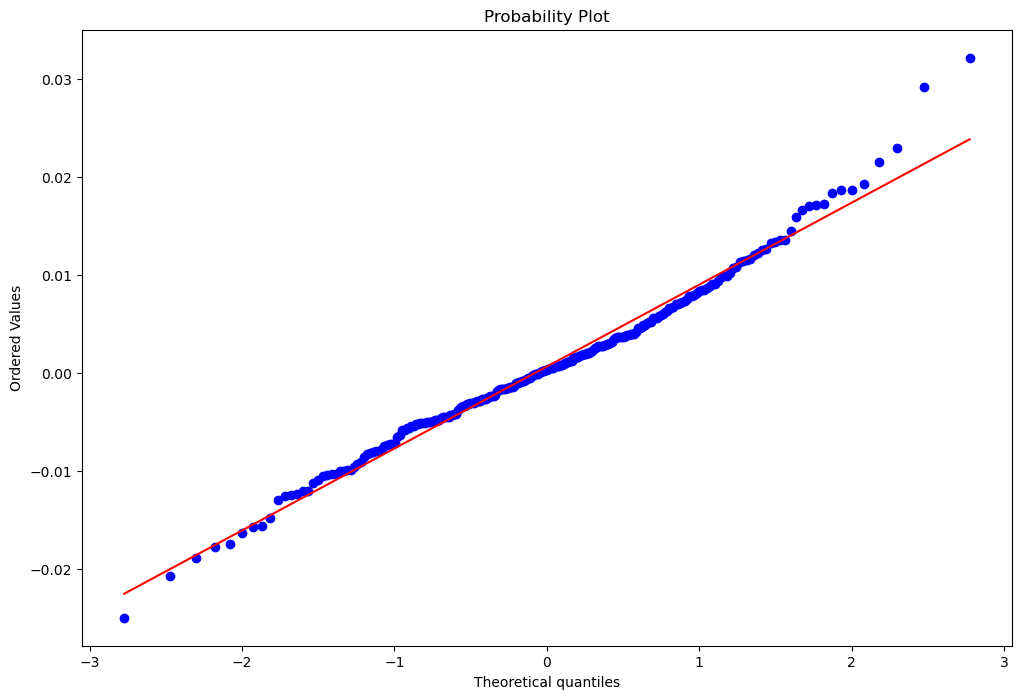

In [5]:
pf.plot_return('qq')

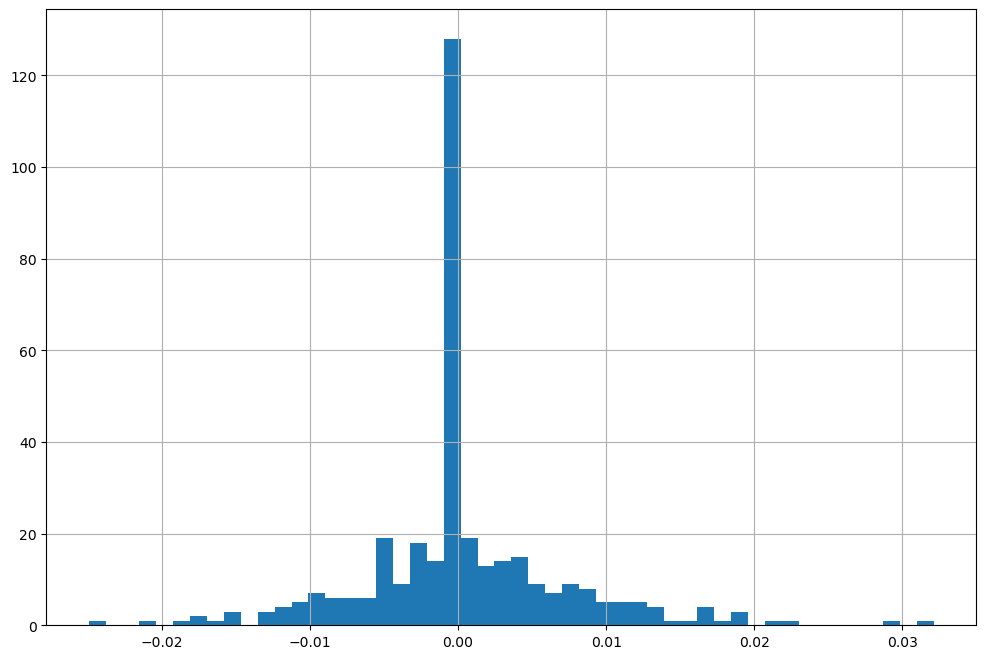

In [6]:
pf.plot_return('histogram')

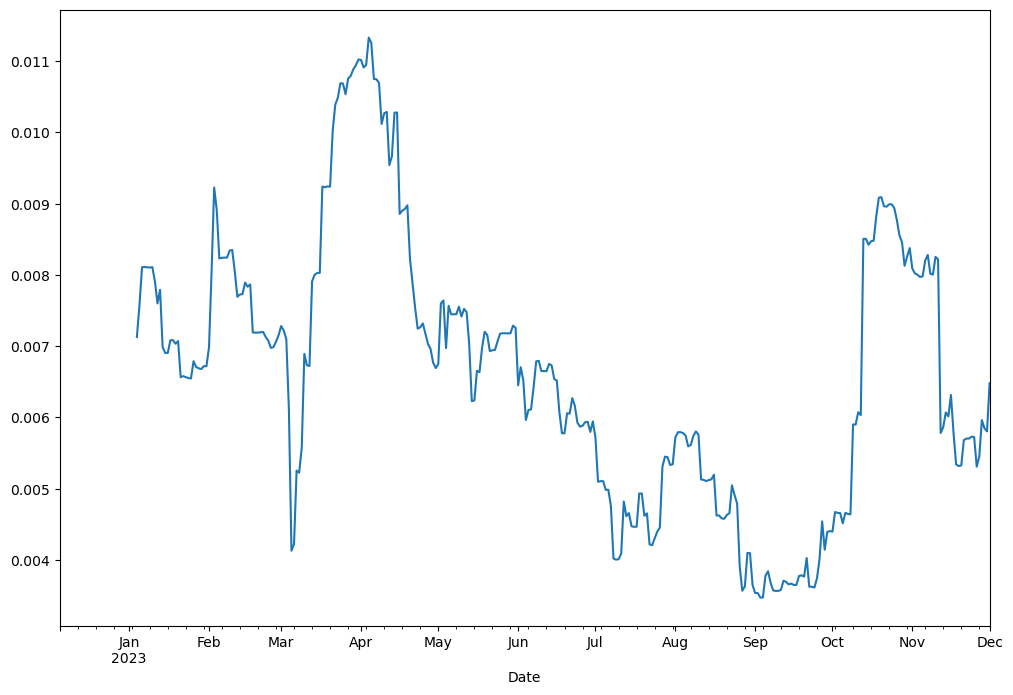

In [7]:
pf.plot_return('volatility')

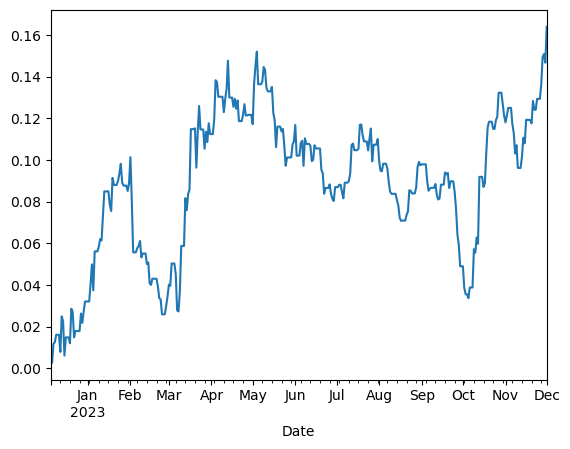

In [8]:
pf.plot_return()

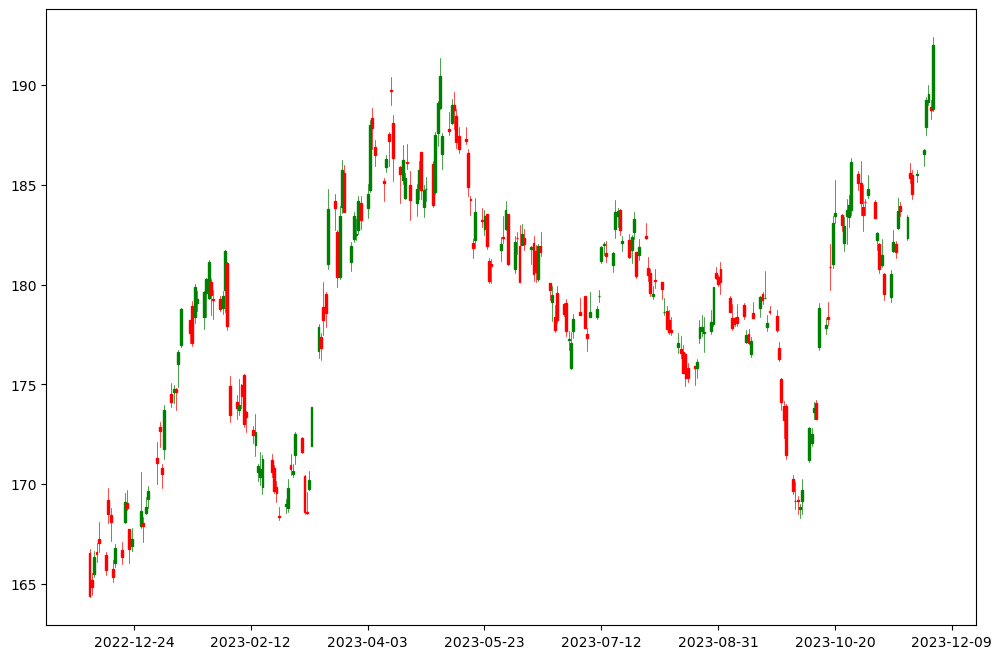

In [9]:
pf.plot_ohlc()

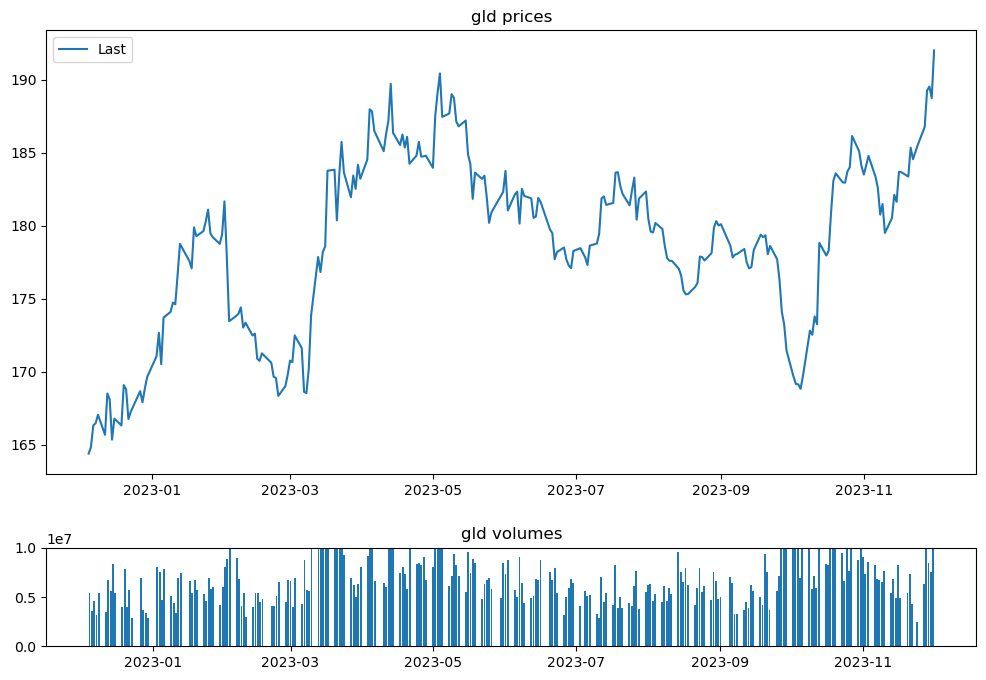

In [10]:
pf.plot_prciesVolumes()

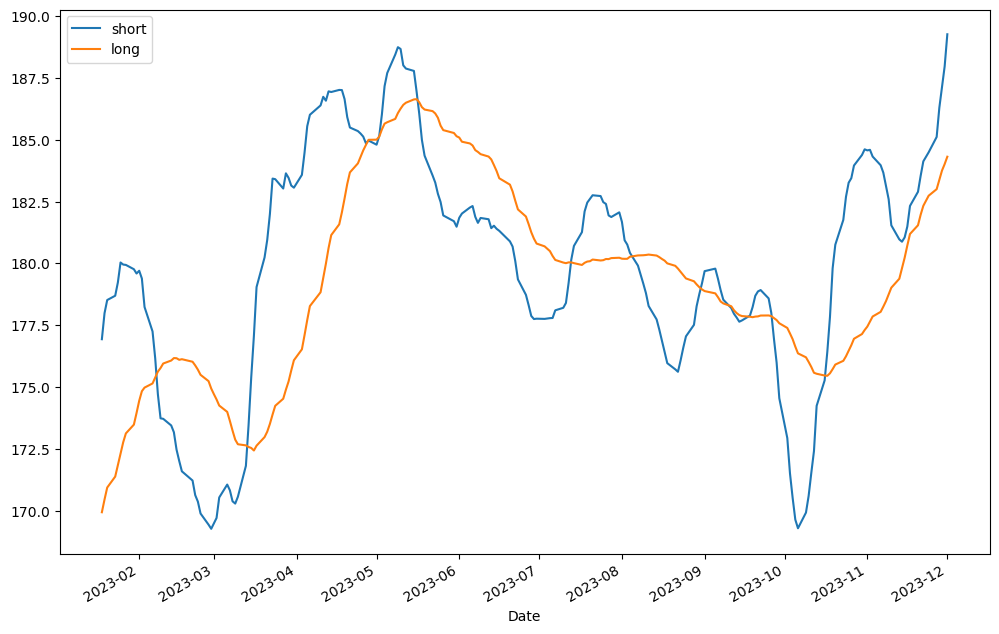

In [11]:
pf.plot_ma()

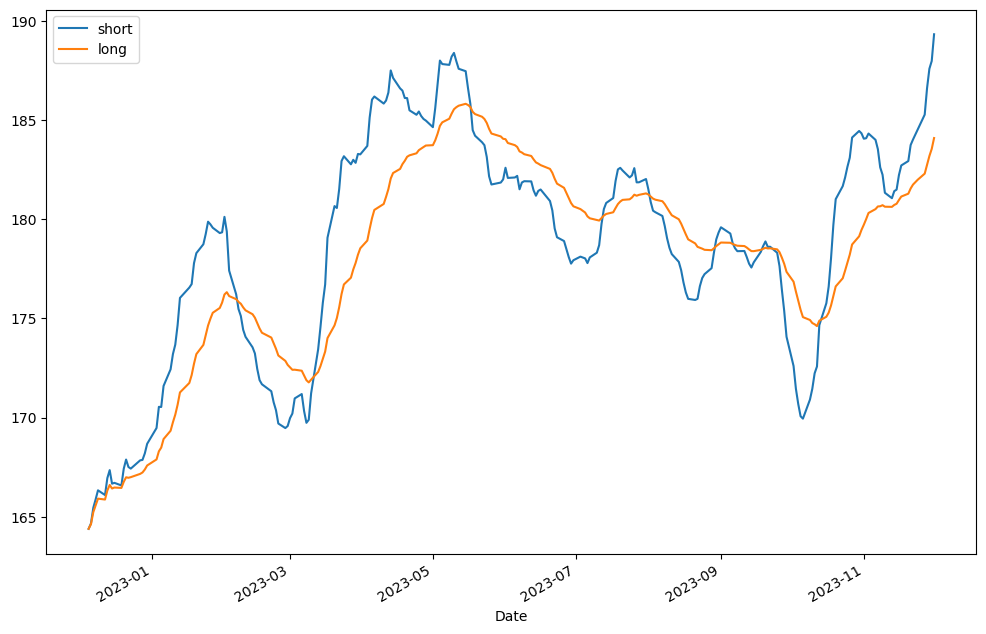

In [12]:
pf.plot_ma('ewm')

---